In [315]:
import numpy as np
import pandas as pd

#Read and preprocessing

In [316]:
data = pd.read_csv('Mall_Customers.csv')
data.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [317]:
data.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


In [318]:
data.isnull().sum()

,0
CustomerID,0
Gender,0
Age,0
Annual Income (k$),0
Spending Score (1-100),0


In [319]:
def min_max_scaler(data, index):
  data[index] = (data[index] - data[index].min()) / (data[index].max() - data[index].min())

def standard_scaler(data, index):
  data[index] = (data[index] - data[index].mean()) / data[index].std()

In [320]:
X = data.iloc[:, 1:]

numeric_col = list(X.drop('Gender', axis=1).columns)
bin_col = ['Gender']

for index in numeric_col:
  min_max_scaler(X, index)

X['Gender'] = X['Gender'].map({'Male': 0.5, 'Female': 1})

X = X.to_numpy()

#Model

In [321]:
class K_Means:

  def __init__(self, k=2,
               centroid_init=None,
               epoch=100):
    self.k = k
    self.iterates = epoch
    self.select_centroid = centroid_init

  def init_centroids(self, X):
    if self.select_centroid == 'firstk':
      return X[:self.k]
    else:
      return X[np.random.choice(X.shape[0], self.k, replace=False)]

  def euclidean_distance(self, point1, point2):
    return np.linalg.norm(point1-point2, axis=0)

  def predict(self, point):
    distances = [self.euclidean_distance(point, cent) for cent in self.centroids]
    return np.argmin(distances)

  def fit(self, data):
    m = data.shape[0]
    cluster_assignments = np.zeros((m, 2))

    cents = self.init_centroids(data)
    original_cent = cents.copy()
    change = True
    itr = 0

    while change and itr < self.iterates:
      change = False

      for i in range(m):
        min_dist = float('inf')
        min_idx = -1
        for j in range(self.k):
          dist = self.euclidean_distance(data[i, :], cents[j, :])

          if dist < min_dist:
            min_dist = dist
            min_idx = j

          if cluster_assignments[i, 0] != min_idx:
            change = True

          cluster_assignments[i, :] = min_idx, min_dist

        for cent in range(self.k):
          points = data[cluster_assignments[:, 0] == cent]
          if points.size > 0:
            cents[cent, :] = np.mean(points, axis=0)

      itr += 1
    self.centroids = cents

    return cents, cluster_assignments, itr, original_cent

#Find optimal k value and train kmean with it


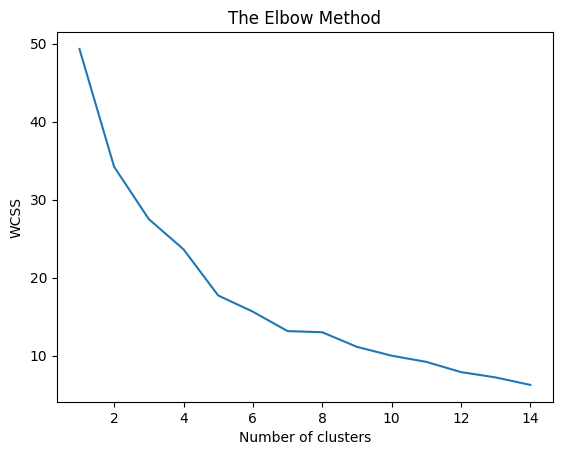

In [322]:
def elbow(cluster_assignment):
  return np.sum(np.array([x ** 2 for x in list(cluster_assignment[:, 1])]))

wcss = []
for i in range(1, 15):
  model = K_Means(k=i, centroid_init='firstk', epoch=200)
  centroid, cluster_assign, itr, origin_ = model.fit(X)
  wcss.append(elbow(cluster_assign))

plt.plot(range(1, 15), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [323]:
model = K_Means(k=5, centroid_init='firstk', epoch=500)
centroid, cluster_assign, itr, origin_ = model.fit(X)

#Visualize clusters

<Figure size 1500x1000 with 0 Axes>

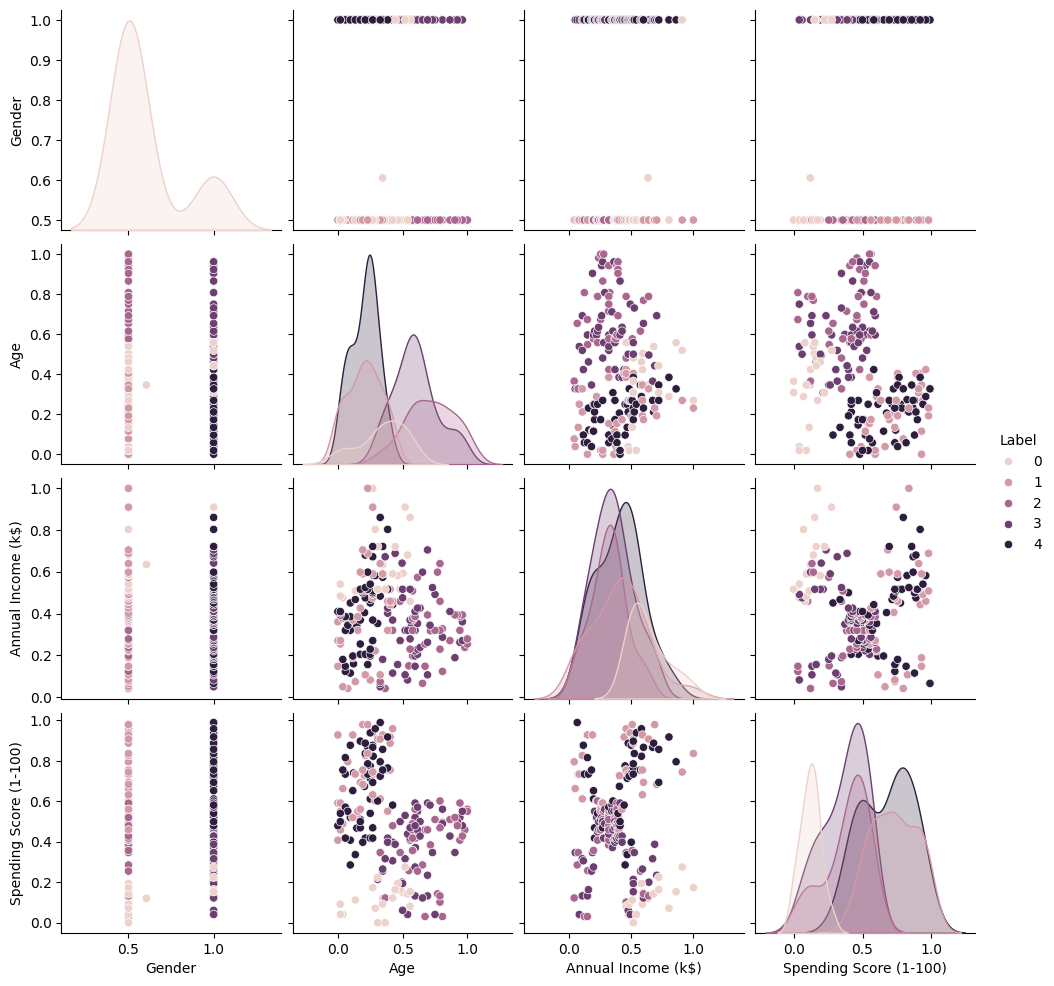

In [324]:
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.DataFrame(X, columns=list(data.columns)[1:])
df['Label'] = np.array(cluster_assign[:, 0], dtype=int)

plt.figure(figsize=(15,10))
sns.pairplot(df, hue='Label')
plt.show()

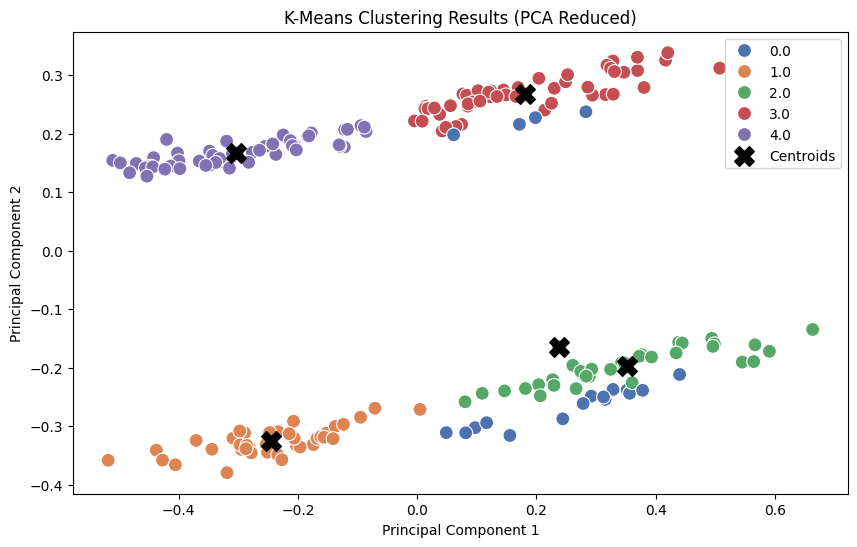

In [326]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X)
centroid2d = pca.transform(centroid)

df = pd.DataFrame(X_reduced, columns=['Principal Component 1', 'Principal Component 2'])
df['Cluster'] = cluster_assign[:, 0]

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Principal Component 1', y='Principal Component 2', hue='Cluster', palette='deep', s=100)
plt.scatter(centroid2d[:, 0], centroid2d[:, 1], marker='X', s=200, color='black', label='Centroids')
plt.title("K-Means Clustering Results (PCA Reduced)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.show()

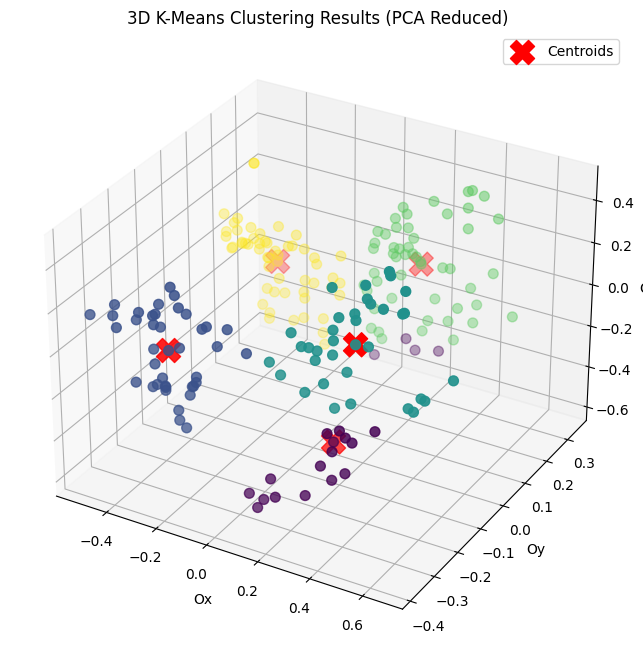

In [327]:
pca_3d = PCA(n_components=3)
X_reduced_3d = pca_3d.fit_transform(X)
centroid3d = pca_3d.transform(centroid)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_reduced_3d[:, 0], X_reduced_3d[:, 1], X_reduced_3d[:, 2], c=cluster_assign[:, 0], s=50, cmap='viridis')

ax.scatter(centroid3d[:, 0], centroid3d[:, 1], centroid3d[:, 2], color='red', s=300, label='Centroids', marker='X')
ax.set_title("3D K-Means Clustering Results (PCA Reduced)")
ax.set_xlabel("Ox")
ax.set_ylabel("Oy")
ax.set_zlabel("Oz")
ax.legend()
plt.show()